# 3. Pricing Recommendations & Revenue Simulation

In this notebook, we use the trained pricing model to:

- Generate **predicted prices** for historical listings
- Compute **price deltas** (model vs. actual marketplace prices)
- Flag **underpriced** and **overpriced** items
- Apply simple, interpretable **pricing rules** to suggest new prices
- Run **revenue simulations** under different pricing scenarios

This turns the modeling work from Notebook 2 into **business-facing pricing recommendations**.

In [78]:
# 3.1 Imports & Configuration

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

plt.style.use("seaborn-v0_8")
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

DATA_PROCESSED_PATH = "../data/processed"
MODELS_PATH = "../models"

### 3.2 Load Final Model & Base Listings Data

We load:

- The **final trained model** from `models/final_model_random_forest.pkl`
- The **cleaned listings table** from `data/processed/cleaned_listings.csv`

Then we rebuild the feature matrix using the *same feature engineering* logic as in Notebook 2 to ensure consistency.

In [79]:
model_path = os.path.join(MODELS_PATH, "final_model_xgboost.pkl")
final_model = joblib.load(model_path)

listings_path = os.path.join(DATA_PROCESSED_PATH, "cleaned_listings.csv")
base_df = pd.read_csv(listings_path)

print("Model loaded from:", model_path)
print("Listings shape:", base_df.shape)
base_df.head()

Model loaded from: ../models/final_model_xgboost.pkl
Listings shape: (112086, 29)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state,product_volume_cm3,shipping_time_days,delivery_delay_days
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,cool_stuff,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,27277,volta redonda,SP,"3,528.0000",7.0000,-9.0000
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,pet_shop,56.0000,239.0000,2.0000,"30,000.0000",50.0000,30.0000,40.0000,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,3471,sao paulo,SP,"60,000.0000",16.0000,-3.0000
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,moveis_decoracao,59.0000,695.0000,2.0000,"3,050.0000",33.0000,13.0000,33.0000,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,37564,borda da mata,MG,"14,157.0000",7.0000,-14.0000
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,perfumaria,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,14403,franca,SP,"2,400.0000",6.0000,-6.0000
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,ferramentas_jardim,59.0000,409.0000,1.0000,"3,750.0000",35.0000,40.0000,30.0000,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,87900,loanda,PR,"42,000.0000",25.0000,-16.0000


### 3.3 Rebuild Modeling Dataset (Same as Notebook 2)

To generate predictions that are consistent with training, we must **reuse the exact same feature engineering pipeline** as in Notebook 2:

- Category-level stats (median/mean/std/count)
- Seller-level stats (median price, avg freight, total items)
- Pricing ratios (price/category median, price/volume, freight/price)
- Time features (purchase month, day of week)

We wrap this logic into a helper function that takes the cleaned listings and returns:

- `listings_model` – enriched dataframe with all engineered features  
- `model_df` – final modeling dataframe (features + target)  
- `X` – feature matrix used for the model  
- `y` – target (`price`, only for reference here)

In [80]:
# 3.3 Rebuild modeling dataset using the SAME pipeline as Notebook 2

def build_model_dataset(df_raw: pd.DataFrame):
    """
    Recreate the modeling dataset exactly as in Notebook 2.
    
    Returns:
        listings_model : dataframe with all engineered features
        model_df       : subset with feature_cols + price (no missing)
        X              : feature matrix
        y              : target (price)
    """
    df = df_raw.copy()
    
    # --- Sanity checks ---
    assert "category_english" in df.columns, "category_english column missing."
    assert "product_volume_cm3" in df.columns, "product_volume_cm3 missing."

    # 1) Category-level aggregations
    category_stats = df.groupby("category_english").agg(
        category_median_price=("price", "median"),
        category_mean_price=("price", "mean"),
        category_price_std=("price", "std"),
        category_count=("price", "count"),
    ).reset_index()

    df = df.merge(category_stats, on="category_english", how="left")

    # 2) Seller-level features
    seller_stats = df.groupby("seller_id").agg(
        seller_median_price=("price", "median"),
        seller_avg_freight=("freight_value", "mean"),
        seller_total_items=("order_id", "count"),
    ).reset_index()

    df = df.merge(seller_stats, on="seller_id", how="left")

    # 3) Pricing ratios
    df["price_to_category_median"] = (
        df["price"] / df["category_median_price"]
    )

    df["price_to_volume"] = (
        df["price"] / df["product_volume_cm3"]
    )

    df["freight_ratio"] = (
        df["freight_value"] / df["price"]
    )

    # 4) Time features
    purchase_dt = pd.to_datetime(df["order_purchase_timestamp"])
    df["purchase_month"] = purchase_dt.dt.month
    df["purchase_dayofweek"] = purchase_dt.dt.dayofweek

    # 5) Final feature set (must match Notebook 2)
    feature_cols = [
        "product_weight_g",
        "product_volume_cm3",
        "freight_value",
        "category_median_price",
        "category_mean_price",
        "category_price_std",
        "category_count",
        "seller_median_price",
        "seller_avg_freight",
        "seller_total_items",
        "purchase_month",
        "purchase_dayofweek",
    ]
    target_col = "price"

    model_df = df[feature_cols + [target_col]].dropna()

    X = model_df[feature_cols]
    y = model_df[target_col]

    return df, model_df, X, y


# Use the cleaned listings loaded in 3.2 (base_df)
listings_model, model_df, X, y = build_model_dataset(base_df)

print("listings_model shape:", listings_model.shape)
print("model_df shape      :", model_df.shape)
print("X shape, y shape    :", X.shape, y.shape)

model_df.head()

listings_model shape: (112086, 41)
model_df shape      : (110469, 13)
X shape, y shape    : (110469, 12) (110469,)


,product_weight_g,product_volume_cm3,freight_value,category_median_price,category_mean_price,category_price_std,category_count,seller_median_price,seller_avg_freight,seller_total_items,purchase_month,purchase_dayofweek,price
0,650.0000,"3,528.0000",13.2900,129.9900,159.6342,149.9355,"3,783.0000",55.9000,19.2843,151,9,2,58.9000
1,"30,000.0000","60,000.0000",19.9300,89.7000,105.0856,107.4243,"1,941.0000",45.9000,20.2342,143,4,2,239.9000
2,"3,050.0000","14,157.0000",17.8700,65.4900,86.4929,79.1731,"8,328.0000",209.0000,19.2107,14,1,6,199.0000
3,200.0000,"2,400.0000",12.7900,84.9900,116.7373,101.8749,"3,419.0000",49.9900,17.3156,16,8,2,12.9900
4,"3,750.0000","42,000.0000",18.1400,59.9000,98.3604,120.0718,"4,314.0000",87.9000,20.9017,29,2,5,199.9000


## 3.4 Generate Predicted Prices

Using the final model trained in Notebook 2, we now generate predicted prices for each listing.

We compute:

- **predicted_price** – the model's estimate  
- **price_delta** – difference between predicted and actual price  
- **delta_pct** – percentage difference, useful for mispricing detection  

These values form the basis for:
- Identifying underpriced / overpriced listings  
- Applying pricing rules  
- Running revenue simulations  

In [81]:
# 3.4 Predict prices for the modeling dataset

predicted = final_model.predict(X)

# Attach predictions to model_df
model_df["actual_price"] = y
model_df["predicted_price"] = predicted

# Calculate absolute and relative differences
model_df["price_delta"] = model_df["predicted_price"] - model_df["actual_price"]
model_df["delta_pct"] = model_df["price_delta"] / model_df["actual_price"]

# Sort by largest underpricing (most interesting cases)
model_df_sorted = model_df.sort_values(by="delta_pct", ascending=False)

model_df[["actual_price", "predicted_price", "price_delta", "delta_pct"]].head(10)

,actual_price,predicted_price,price_delta,delta_pct
0,58.9000,66.3402,7.4402,0.1263
1,239.9000,195.9128,-43.9872,-0.1834
2,199.0000,201.6323,2.6323,0.0132
3,12.9900,38.9896,25.9996,2.0015
4,199.9000,156.8597,-43.0403,-0.2153
5,21.9000,33.8876,11.9876,0.5474
6,19.9000,20.9883,1.0883,0.0547
7,810.0000,845.2799,35.2799,0.0436
8,145.9500,120.8426,-25.1074,-0.1720
9,53.9900,59.3762,5.3862,0.0998


## 3.5 Mispricing Detection

Now that we have realistic predicted prices (no leakage), we classify each item as:

- **Underpriced**: model suggests price should be 20%+ higher  
- **Overpriced**: model suggests price should be 20%+ lower  
- **Fair**: within ±20% of predicted fair price  

These classifications will drive the pricing recommendation logic.

In [82]:
UNDER_THRESHOLD = 0.20
OVER_THRESHOLD = -0.20

def classify(row):
    if row["delta_pct"] > UNDER_THRESHOLD:
        return "underpriced"
    elif row["delta_pct"] < OVER_THRESHOLD:
        return "overpriced"
    else:
        return "fair"

model_df["pricing_flag"] = model_df.apply(classify, axis=1)

model_df["pricing_flag"].value_counts(normalize=True)

pricing_flag
fair          0.6236
underpriced   0.2605
overpriced    0.1158
Name: proportion, dtype: float64

## 3.6 Pricing Adjustment Rules

Using the mispricing flags, we apply controlled, interpretable pricing rules:

### Underpriced
If the model indicates the item is **20%+ below fair value**, we increase by:
- min(30%, move 30% toward model prediction)

### Overpriced
If the model indicates the item is **20%+ above fair value**, we decrease by:
- min(5%, move 30% toward model prediction)

### Fair
Price remains unchanged.

These conservative rules avoid large jumps and keep prices business-friendly.

In [83]:
MAX_UP = 0.30      # max +10% increase
MAX_DOWN = 0.05    # max -15% decrease

def recommend_price(row):
    actual = row["actual_price"]
    pred   = row["predicted_price"]
    flag   = row["pricing_flag"]

    # Move halfway toward model price
    halfway_price = 0.7 * actual + 0.3 * pred
    raw_adj_pct = (halfway_price - actual) / actual

    # Apply rules
    if flag == "underpriced":
        adj_pct = min(max(raw_adj_pct, 0), MAX_UP)       # upward capped
    elif flag == "overpriced":
        adj_pct = max(min(raw_adj_pct, 0), -MAX_DOWN)    # downward capped
    else:
        adj_pct = 0.0

    return actual * (1 + adj_pct)

model_df["recommended_price"] = model_df.apply(recommend_price, axis=1)

model_df[["actual_price", "predicted_price", "recommended_price", "pricing_flag"]].head(10)

,actual_price,predicted_price,recommended_price,pricing_flag
0,58.9000,66.3402,58.9000,fair
1,239.9000,195.9128,239.9000,fair
2,199.0000,201.6323,199.0000,fair
3,12.9900,38.9896,16.8870,underpriced
4,199.9000,156.8597,189.9050,overpriced
5,21.9000,33.8876,25.4963,underpriced
6,19.9000,20.9883,19.9000,fair
7,810.0000,845.2799,810.0000,fair
8,145.9500,120.8426,145.9500,fair
9,53.9900,59.3762,53.9900,fair


## 3.7 Revenue Simulation

Now that we have:

- `actual_price`
- `recommended_price`
- `pricing_flag` (underpriced / overpriced / fair)

We can estimate the **impact of dynamic pricing**.

Since each row in the Olist order_items dataset represents **one unit sold**, revenue per row is simply:

- **Actual revenue** = actual_price  
- **Recommended revenue** = recommended_price

We simulate two scenarios:

### **Scenario A — Current Marketplace Pricing**
Revenue based on actual historical prices.

### **Scenario B — Dynamic Pricing Strategy**
Revenue if our recommended prices had been used.

We then compute:

- Total revenue uplift  
- Percentage uplift  
- Revenue changes by category  
- Distribution of price changes

In [84]:
# 3.7 Row-level revenue calculations

model_df["revenue_actual"] = model_df["actual_price"]
model_df["revenue_recommended"] = model_df["recommended_price"]

# Summaries
total_actual = model_df["revenue_actual"].sum()
total_reco   = model_df["revenue_recommended"].sum()

uplift_abs = total_reco - total_actual
uplift_pct = (uplift_abs / total_actual) * 100

print(f"Total actual revenue      : {total_actual:,.2f}")
print(f"Total recommended revenue : {total_reco:,.2f}")
print(f"Absolute uplift           : {uplift_abs:,.2f}")
print(f"Percentage uplift         : {uplift_pct:.2f}%")

Total actual revenue      : 12,401,493.63
Total recommended revenue : 12,517,756.37
Absolute uplift           : 116,262.74
Percentage uplift         : 0.94%


### 3.7.1 Revenue by Category

While overall revenue uplift is useful, it is also important to understand **where** the pricing strategy creates (or loses) value.

In this section, we compute:

- Actual revenue per category  
- Recommended revenue per category  
- Absolute uplift per category  
- Percentage uplift per category  

This helps identify categories that:
- Benefit most from upward price corrections  
- Suffer from downward adjustments  
- Show stable or neutral pricing behavior  

This breakdown is valuable for business teams in charge of pricing strategy, category management, and merchandising.

In [85]:
# 3.7.1 Revenue by Category (fixed)

# Make sure these columns exist in model_df from earlier steps:
# revenue_actual, revenue_recommended

# 1) Build a dataframe that has category + revenues
sim_df = listings_model.loc[model_df.index, ["category_english"]].copy()

sim_df["revenue_actual"] = model_df["revenue_actual"].values
sim_df["revenue_recommended"] = model_df["revenue_recommended"].values

# 2) Aggregate revenue by category
revenue_by_cat = (
    sim_df
    .groupby("category_english")[["revenue_actual", "revenue_recommended"]]
    .sum()
    .sort_values("revenue_actual", ascending=False)
)

# 3) Uplift metrics
revenue_by_cat["uplift_abs"] = (
    revenue_by_cat["revenue_recommended"] - revenue_by_cat["revenue_actual"]
)

revenue_by_cat["uplift_pct"] = (
    revenue_by_cat["uplift_abs"] / revenue_by_cat["revenue_actual"] * 100
)

revenue_by_cat.head(10)

,revenue_actual,revenue_recommended,uplift_abs,uplift_pct
category_english,,,,
health_beauty,"1,188,419.3900","1,200,351.6742","11,932.2842",1.0040
watches_gifts,"1,085,272.8700","1,094,687.9652","9,415.0952",0.8675
bed_bath_table,"1,025,166.4400","1,033,000.2393","7,833.7993",0.7641
sports_leisure,"925,926.1400","935,722.7210","9,796.5810",1.0580
computers_accessories,"856,207.8900","865,398.5324","9,190.6424",1.0734
furniture_decor,"720,312.4600","727,933.9473","7,621.4873",1.0581
cool_stuff,"603,896.1300","607,612.9364","3,716.8064",0.6155
housewares,"602,953.1200","610,263.1579","7,310.0379",1.2124
auto,"525,625.5500","531,875.9963","6,250.4463",1.1891


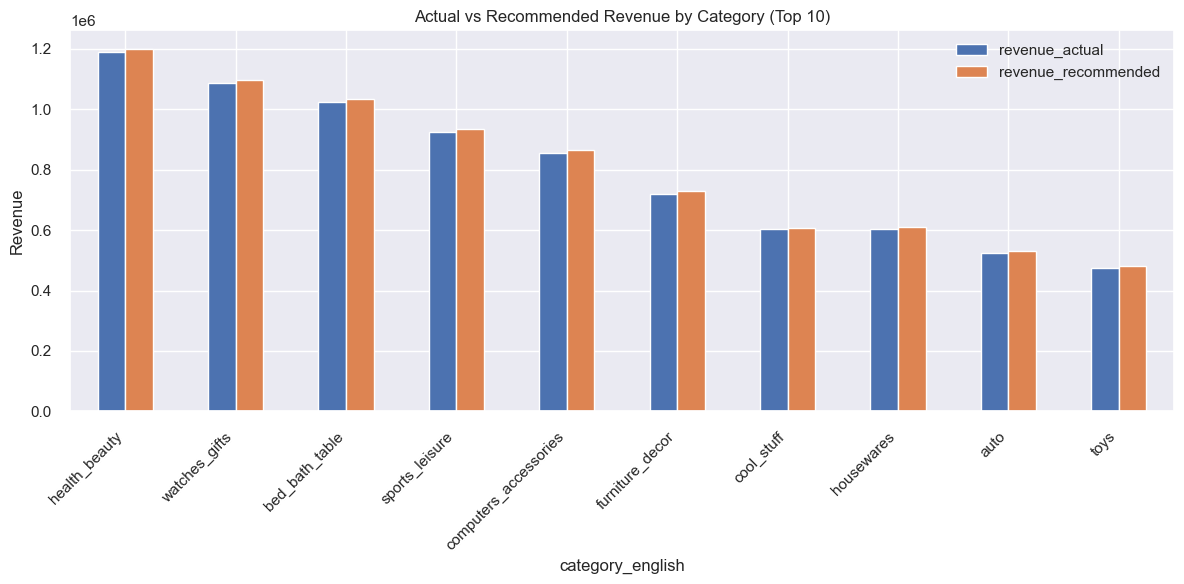

In [89]:
ax = top10[["revenue_actual", "revenue_recommended"]].plot(
    kind="bar", figsize=(12, 6)
)
ax.set_title("Actual vs Recommended Revenue by Category (Top 10)")
ax.set_ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [87]:
# 3.7.2 Revenue impact by pricing_flag

# Sanity check: make sure required columns exist
required_cols = {"pricing_flag", "revenue_actual", "revenue_recommended"}
missing = required_cols - set(model_df.columns)
assert not missing, f"Missing columns in model_df: {missing}"

# Aggregate revenue by pricing segment
revenue_by_flag = (
    model_df
    .groupby("pricing_flag")[["revenue_actual", "revenue_recommended"]]
    .sum()
    .sort_values("revenue_actual", ascending=False)
)

# Add uplift (absolute and percentage)
revenue_by_flag["uplift_abs"] = (
    revenue_by_flag["revenue_recommended"] - revenue_by_flag["revenue_actual"]
)

revenue_by_flag["uplift_pct"] = (
    revenue_by_flag["uplift_abs"] / revenue_by_flag["revenue_actual"] * 100
)

# Also show share of total revenue (actual)
total_actual_rev = revenue_by_flag["revenue_actual"].sum()
revenue_by_flag["share_of_total_actual"] = (
    revenue_by_flag["revenue_actual"] / total_actual_rev * 100
)

revenue_by_flag

,revenue_actual,revenue_recommended,uplift_abs,uplift_pct,share_of_total_actual
pricing_flag,,,,,
fair,"8,893,841.8900","8,893,841.8900",0.0000,0.0000,71.7159
overpriced,"1,955,433.1500","1,857,661.4925","-97,771.6575",-5.0000,15.7677
underpriced,"1,552,218.5900","1,766,252.9838","214,034.3938",13.7889,12.5164


<Figure size 800x500 with 0 Axes>

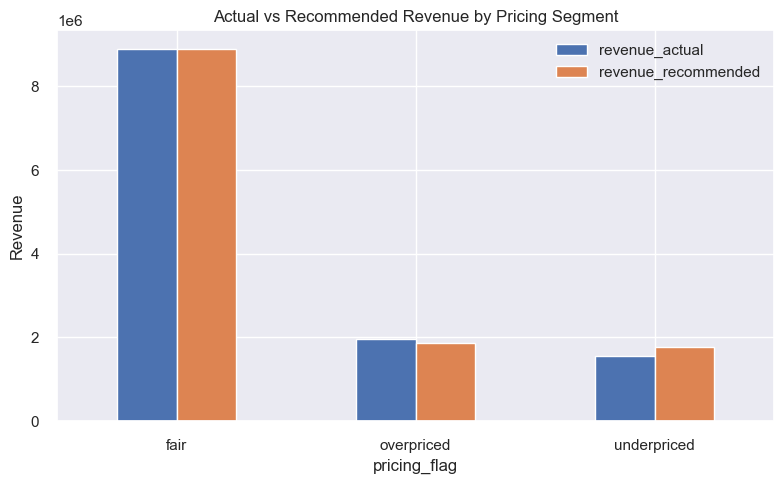

In [88]:
plt.figure(figsize=(8, 5))
revenue_by_flag[["revenue_actual", "revenue_recommended"]].plot(
    kind="bar",
    figsize=(8, 5)
)
plt.title("Actual vs Recommended Revenue by Pricing Segment")
plt.ylabel("Revenue")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()